<a href="https://colab.research.google.com/github/yiyoungkim/yy/blob/main/CV_AL2_effi_t4(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AdamP optimizer 사용

Label Smoothing

EfficientNetV2 모델 사용

CosineAnnealingLR 스케줄러 사용

agument에  transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),                                                   transforms.GaussianBlur(3)]), p=0.1) 추가

multi-scale input 사용




In [44]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



The goal is to solve the fine-grained image classification train the model using hyperparameter tuning, data augmentation, etc., and write a report with a detailed analysis of the results.
 - Is the problem solved in an appropriate way?
- Are different hyperparameters and data augmentation used for training and are the results compared and analyzed?
- Is the use of appropriate visualization tools and experiment tools for your reports?
e.g., GradCAM, Weight & Biases, etc.

The goal is to improve find-grained classification accuracy by modifying the model with your ideas

In [ ]:
!pip install efficientnet_pytorch
!pip3 install adamp

In [45]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import ConcatDataset
from torchvision.transforms import RandAugment

import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

# from adabelief_pytorch import AdaBelief
from torch.optim.lr_scheduler import CosineAnnealingLR

from efficientnet_pytorch import EfficientNet
from adamp import AdamP

# Set random seed
seed = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)




cuda


In [46]:

### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/drive/MyDrive/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/drive/MyDrive/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)


    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)


In [47]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'



In [48]:

### Data Preprocessing ###
transforms_train_origin = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor(),
                                       ])
transforms_test = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor(),
                                       ])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    # transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),
    AdjustContrast(factor=2.0),
    AdjustBrightness(factor=1.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(),
                                                        transforms.GaussianBlur(3)]), p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


BATCH_SIZE = 8

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# Duplicate original data for data augmentation
train_set_augmented = CUB2011(mode='train',transform=transforms_train_g_v)

# Concatenate the datasets to create a new training dataset
train_set_combined = ConcatDataset([train_set_origin,train_set_augmented])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))
# print('Num of each dataset: ',len(train_set_origin),len(train_set_augmented), len(train_set_augmented2), len(train_set_mixup))


#-----------------------------------------------------------------------
# DataLoader class creates mini-batches for training deep learning models
# DataLoader divides the entire dataset into batches of size BATCH_SIZE

train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  4720 296 298
Loaded dataloader


In [ ]:
# !pip install --upgrade adabelief-pytorch

In [49]:
def multi_scale_input(image, model):
  """
  Performs multi-scale inference on the input image.

  Args:
    image: A PyTorch tensor representing the input image.
    model: A PyTorch model.

  Returns:
    A PyTorch tensor representing the average of the model's predictions on the three resized images.
  """

  # Resize the input image to three different sizes
  image_448 = F.interpolate(image, size=(448, 448), mode='bilinear', align_corners=False)
  image_384 = F.interpolate(image, size=(384, 384), mode='bilinear', align_corners=False)
  image_320 = F.interpolate(image, size=(320, 320), mode='bilinear', align_corners=False)

  # Pass each resized image through the model
  output_448 = model(image_448)
  output_384 = model(image_384)
  output_320 = model(image_320)

  # Average the outputs of the three models
  output = (output_448 + output_384 + output_320) / 3

  return output

In [55]:

### Model / Optimizer ###
EPOCH = 10

lr = 0.0001
model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', pretrained=True, nclass=50)
# print(model)

model.to(DEVICE)

# Apply Weight Decay: Prevent overfitting with L2 regularization
# optimizer = AdaBelief(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-16, weight_decouple=True, rectify=True)
# optimizer = AdaBelief(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-16, weight_decouple=True, rectify=True, weight_decay=1e-5)
optimizer = AdamP(model.parameters(),lr=lr)
# Initialize Cosine Annealing LR Scheduler

dataset_size = len(train_set_combined) # Size of the training dataset
T_max = dataset_size / BATCH_SIZE  # Number of epochs for one cycle
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0.001)

print("Created a learning model and optimizer")



Using cache found in /root/.cache/torch/hub/hankyul2_EfficientNetV2-pytorch_main


Created a learning model and optimizer


In [56]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  criterion = nn.CrossEntropyLoss(label_smoothing=0.11)

  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    # output = model(image)
    # Pass the input images through the multi-scale input function
    output = multi_scale_input(image, model)
    optimizer.zero_grad()
    # Calculate the loss
    train_loss = criterion(output, target)

    # Backpropagate the loss and update the model parameters

    train_loss.backward()
    optimizer.step()

    if i%10 ==0:
      print(f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0

  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)

      # Pass the input images through the multi-scale input function
      output = multi_scale_input(image, model)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [57]:

#### Mian ###
start = time.time()
best = 0

train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/590]	loss: 3.901827
Train Epoch: 0 [10/590]	loss: 3.866061
Train Epoch: 0 [20/590]	loss: 3.914343
Train Epoch: 0 [30/590]	loss: 3.863409
Train Epoch: 0 [40/590]	loss: 3.900664
Train Epoch: 0 [50/590]	loss: 3.785902
Train Epoch: 0 [60/590]	loss: 3.853608
Train Epoch: 0 [70/590]	loss: 3.707992
Train Epoch: 0 [80/590]	loss: 3.623922
Train Epoch: 0 [90/590]	loss: 3.613714
Train Epoch: 0 [100/590]	loss: 3.586840
Train Epoch: 0 [110/590]	loss: 3.521674
Train Epoch: 0 [120/590]	loss: 3.469816
Train Epoch: 0 [130/590]	loss: 3.545355
Train Epoch: 0 [140/590]	loss: 3.265329
Train Epoch: 0 [150/590]	loss: 3.330130
Train Epoch: 0 [160/590]	loss: 3.225089
Train Epoch: 0 [170/590]	loss: 3.240673
Train Epoch: 0 [180/590]	loss: 2.925042
Train Epoch: 0 [190/590]	loss: 3.005818
Train Epoch: 0 [200/590]	loss: 3.281811
Train Epoch: 0 [210/590]	loss: 3.065963
Train Epoch: 0 [220/590]	loss: 2.688796
Train Epoch: 0 [230/590]	loss: 2.939045
Train Epoch: 0 [240/590]	loss: 3.021735
Train Epoch

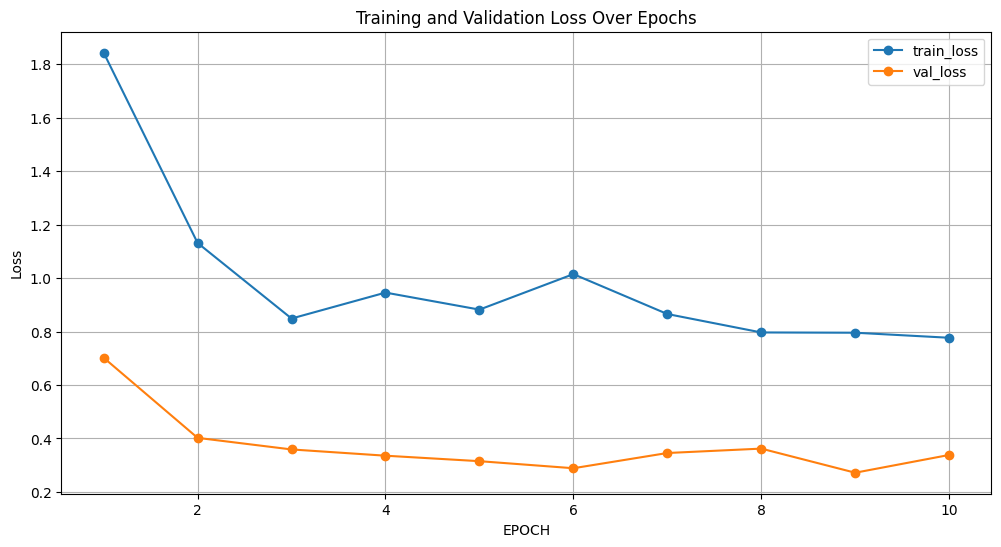

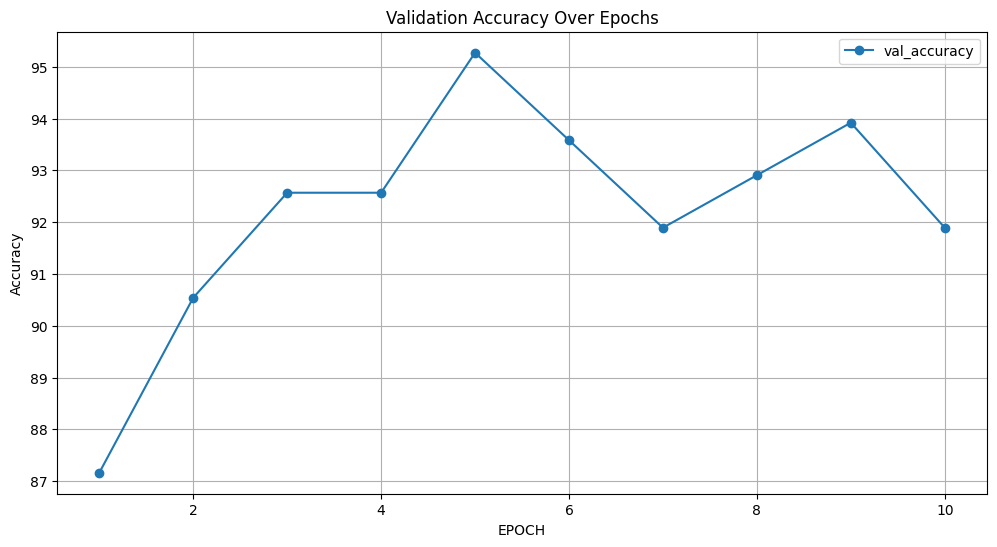

In [59]:
# Plot the loss values
import matplotlib.pyplot as plt

# Move train_loss and val_loss tensors to CPU and convert them to NumPy arrays
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.
              cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

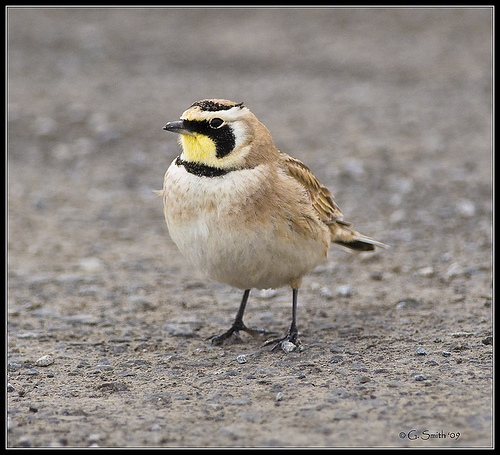

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
img_path = test_set.image_folder[random_index]
img_path = os.path.join('/content/drive/MyDrive/datasets/test', img_path)
display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)